In [1]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import csv
import time
import collections
import random
import timeit
import math

import scipy,sklearn,pylab
from scipy import io

from sklearn import model_selection,covariance
from sklearn.model_selection import train_test_split,KFold
from sklearn.feature_extraction import DictVectorizer

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['figure.figsize'] = (6,4)

In [2]:
letters = scipy.io.loadmat("hw6_data_dist/hw6_data_dist/letters_data")

In [3]:
letters


{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Mar 24 11:58:28 2017',
 '__version__': '1.0',
 'test_x': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'train_x': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'train_y': array([[23],
        [ 7],
        [16],
        ..., 
        [13],
        [15],
        [19]], dtype=uint8)}

In [4]:
class NNet:
    def __init__(self,vpath=None,wpath=None,h_units = 200, gaus = False):
        self.h_units = h_units
        self.losspt = []
        if vpath:
            self.V = np.loadtxt(vpath,dtype = np.float64)
        else:
            if gaus:
                self.V = np.random.normal(
                    0,1/math.sqrt(785),
                    size=(h_units,785)).astype(np.float64)
            else:
                self.V = np.random.uniform(
                    -1/math.sqrt(785),1/math.sqrt(785),
                    size =(h_units,785)).astype(np.float64)
        if wpath:
            self.W = np.loadtxt(wpath,dtype = np.float64)
        else:
            if gaus:
                self.W = np.random.normal(
                    0,1/math.sqrt(h_units+1),
                    size=(26,h_units+1)).astype(np.float64)
            else:
                self.W = np.random.uniform(
                    -1/math.sqrt(h_units+1),1/math.sqrt(h_units+1),
                    size=(26,h_units+1)).astype(np.float64) 
        
    def s(self,x):
        e_x = np.exp(x - np.max(x),dtype=np.float64)
        return e_x / e_x.sum()
    def sig(self,x):
        return scipy.special.expit(x)
    def Sf(self,x):            
        return np.apply_along_axis(self.s,0,x)
        
    def Sf2(self,x):
        e_x = np.exp(x - np.max(x),dtype=np.float64)
        return e_x / e_x.sum(axis=0)
    def save(self,vpath,wpath):
        np.savetxt(vpath,self.V)
        np.savetxt(wpath,self.W)
    def updateR(self,X,Y,maskV,e1,e2,batch_size,plot=False):
        H = np.maximum(0,self.V.dot(X.T)) 
        Hb = np.concatenate((H,np.ones((1,batch_size),dtype=np.float64)),0)
        #Hb[maskV]=0
        Z = self.Sf(self.W.dot(Hb))
        S = self.Sf(self.W.dot(Hb))-Y.T
        #DLW = S.dot(Hb.T)
        #DLV = (self.W.T.dot(S)[:-1]*(H>=0)).dot(X)
        #T = self.W.T.dot(S)[:-1]
        #T[H<0]=0    
        #DLV[maskV[:-1]]=0
        if plot: 
            self.losspt.append(self.softloss(Y,Z,batch_size))
        self.V -= e1*((H>=0)*self.W.T.dot(S)[:-1]).dot(X)
        self.W -= e2*S.dot(Hb.T)
    def updateRd(self,X,Y,maskV,e1,e2,batch_size,plot=False):
        H = np.maximum(0,self.V.dot(X.T)) 
        Hb = np.concatenate((H,np.ones((1,batch_size),dtype=np.float64)),0)
        Hb[maskV]=0
        Z = self.Sf(self.W.dot(Hb))
        S = Z-Y.T
        DLW = S.dot(Hb.T)
        DLV = (self.W.T.dot(S)[:-1]*(H>=0)).dot(X)
        DLV[maskV[:-1]]=0
        self.V -= e1*DLV
        self.W -= e2*DLW
    
    def updateS(self,X,Y,maskV,e1,e2,batch_size,l1=0.1,l2=0.1,plot=False):
        H = np.tanh(self.V.dot(X.T))#*maskV
        Hb = np.concatenate((H,np.ones((1,batch_size),dtype=np.float64)),0)
        #Hb[maskV]=0
        Z = scipy.special.expit(self.W.dot(Hb))
        if plot: 
            self.losspt.append(self.logisloss(Y,Z,batch_size))
        S = Z-Y.T
        #DLW = S.dot(Hb.T)
        #DLV = (self.W.T.dot(S)[:-1]*(1-H**2)).dot(X)
        #DLV[maskV[:-1]]=0
        self.V -= e1*(self.W.T.dot(S)[:-1]*(1-H**2)).dot(X)#+2*l1*self.V)#*maskV
        self.W -= e2*S.dot(Hb.T)#+2*l2*self.W)   
    def updateSd(self,X,Y,maskV,e1,e2,batch_size,l1=0.1,l2=0.1,plot=False):
        #H1 = np.tanh(self.V.dot(X.T))#*maskV
        #Hb1 = np.concatenate((H1,np.ones((1,batch_size),dtype=np.float32)),0)
        #Hb1[np.logical_not(maskV)]=0
        #Z1 = scipy.special.expit(self.W.dot(Hb1))
        #S1 = Z1-Y.T
        #DLW1 = S1.dot(Hb1.T)
        #DLV1 = (self.W.T.dot(S1)[:-1]*(1-H1**2)).dot(X)
        
        H = np.tanh(self.V[maskV[:-1]].dot(X.T))#*maskV
        Hb = np.concatenate((H,np.ones((1,batch_size),dtype=np.float64)),0)
        #Z = scipy.special.expit(self.W[:,maskV].dot(Hb))
        S = scipy.special.expit(self.W[:,maskV].dot(Hb))-Y.T
        #DLW = S.dot(Hb.T)
        #DLV = (self.W[:,maskV].T.dot(S)[:-1]*(1-H**2)).dot(X)
        #DLV[maskV[:-1]]=0        
        self.V[maskV[:-1]] -= e1*(self.W[:,maskV].T.dot(S)[:-1]*(
            1-H**2)).dot(X)#+2*l1*self.V)#*maskV
        self.W[:,maskV] -= e2*S.dot(Hb.T)#+2*l2*self.W)   
    def update(self,X,Y,maskV,e1,e2,batch_size,l1=0.1,l2=0.1,plot=False):
        
        H = np.tanh(self.V.dot(X.T))#*maskV
        Hb = np.concatenate((H,np.ones((1,batch_size),dtype=np.float64)),0)
        #Hb[maskV]=0
        #print(Hb.shape)
        #print(self.W.shape)
        Z = self.Sf(self.W.dot(Hb))
        #print(S.shape)
        S = Z-Y.T
        if plot: 
            self.losspt.append(self.softloss(Y,Z,batch_size))
        #DLW = S.dot(Hb.T)
        #DLV = (self.W.T.dot(S)[:-1]*(1-H**2)).dot(X)
        #DLV[maskV[:-1]]=0
        #print(DLW)
        self.V -= e1*(self.W.T.dot(S)[:-1]*(1-H**2)).dot(X)#+2*l1*self.V)#*maskV
        self.W -= e2*S.dot(Hb.T)#+2*l2*self.W)
    def updated(self,X,Y,maskV,e1,e2,batch_size,l1=0.1,l2=0.1,plot=False):
        
        H = np.tanh(self.V[maskV[:-1]].dot(X.T))#*maskV
        Hb = np.concatenate((H,np.ones((1,batch_size),dtype=np.float64)),0)
        #Hb[maskV]=0
        #print(Hb.shape)
        #print(self.W.shape)
        #Z = self.Sf(self.W[:,maskV].dot(Hb))
        #print(S.shape)
        S = self.Sf(self.W[:,maskV].dot(Hb))-Y.T
        #DLW = S.dot(Hb.T)
        #DLV = (self.W[:,maskV].T.dot(S)[:-1]*(1-H**2)).dot(X)
        #DLV[maskV[:-1]]=0
        #print(DLW)
        self.V[maskV[:-1]] -= e1*(self.W[:,maskV].T.dot(S)[:-1]*(
            1-H**2)).dot(X)
        self.W[:,maskV] -= e2*S.dot(Hb.T)#+2*l2*self.W)

    def train(self,data,labels,iterations,e1,e2,batch_size=1,
              tanh=True,sigmoid=False,cool=False,dropout= False,plot=False):

        d = labels.shape[0]
        
        Y = np.zeros((d,26),dtype=np.float64)
        for i in range(d):
            Y[i,labels[i]-1] = 1
 
        X = np.concatenate((data,np.ones((d,1),dtype=np.float64)),1)
        indices= np.arange(d)
        if dropout:
            if tanh: 
                update = self.updated
                if sigmoid:
                    update = self.updateSd
            else:
                update = self.updateRd
        else:
            if tanh: 
                update = self.update
                if sigmoid:
                    update = self.updateS
            else:
                update = self.updateR
        if dropout:
            for i in range(iterations):
                np.random.shuffle(indices)     

                e1p = e1*0.9**i if cool else e1
                e2p = e2*0.9**i if cool else e2
                for j in range(d//batch_size):
                    rmaskV= np.random.binomial(
                        1,0.5,size=self.h_units).astype(bool) 
                    maskV = np.append(rmaskV,[True])
                    update(
                        X[indices[j:j+batch_size]],
                        Y[indices[j:j+batch_size]],
                        maskV,e1=e1p/batch_size,e2=e2p/batch_size,
                        batch_size = batch_size)
        else:
            maskV = None
            for i in range(iterations):
                np.random.shuffle(indices)

                e1p = e1/(i+1) if cool else e1
                e2p = e2/(i+1) if cool else e2
                for j in range(d//batch_size):
                    update(
                        X[indices[j:j+batch_size]],
                        Y[indices[j:j+batch_size]],
                        maskV,e1=e1p/batch_size,e2=e2p/batch_size,
                        batch_size = batch_size,plot=plot)
                                           

    def softloss(self,Y,Z,batch_size):
        return -(Y*(np.log(Z.T))).sum()/batch_size
        
    def logisloss(self,Y,Z,batch_size):
        return -(Y*(np.log(Z.T)) + (1-Y)*(np.log(1-Z.T))).sum()/batch_size
    
    def predictpoint(self,pt,tanh=True,sigmoid=False,dropout=False):
        h= np.tanh(self.V.dot(pt)) if tanh else np.maximum(0,self.V.dot(pt))
        if dropout:
            h = h*1/2
        z= self.sig(self.W.dot(np.append(h,[1]))) if sigmoid else self.s(
            self.W.dot(np.append(h,[1]))) 
        return np.array([1+np.argmax(z)])
    
    def predict(self,data,tanh=True,sigmoid=False,dropout=False):
        d= data.shape[0]
        X = np.concatenate((data,np.ones((d,1),dtype=np.float64)),1)
        H= np.tanh(self.V.dot(X.T)) if tanh else np.maximum(
            0,self.V.dot(X.T))
        if dropout:
            H = 1/2*H
        Hb = np.concatenate((H,np.ones((1,d),dtype=np.float64)),0)

        Z = scipy.special.expit(self.W.dot(Hb)) if sigmoid else self.Sf(
            self.W.dot(Hb))
        
        return (1+np.argmax(Z,0)).reshape(d,1)
    
    def score(self,v,lab,tanh=True,sigmoid=False,dropout=False):
        return 1-(np.count_nonzero(lab-self.predict(
            v,tanh,sigmoid,dropout))/lab.shape[0])
    

In [5]:
let_t, let_v, let_t_label,let_v_label=train_test_split(
    letters['train_x'],letters['train_y'],test_size=0.2)
let_t.shape


(99840, 784)

In [6]:
# def preprocessing function
def preprocess(data,means=None):
    if means is not None:
        return means,((data-means)/255).astype(np.float32)
    else:
        m = np.mean(data,0)
        return m,((data-m)/255).astype(np.float32)

In [7]:
let_t_means,plet_t = preprocess(let_t)

In [8]:
let_v_means,plet_v = preprocess(let_v,let_t_means)

In [9]:
let_means,plet = preprocess(letters['train_x'])

In [10]:
let_f_means,plet_f = preprocess(letters['test_x'],let_means)

In [15]:
nnet = NNet(h_units=200,gaus=True) 

In [ ]:
t0 = time.time()
nnet.train(plet_t,let_t_label,10,0.01,0.01,batch_size = 1,
           tanh=True,sigmoid=True,dropout=False,cool=True,plot=True)
t1 = time.time()
print(t1-t0)

In [ ]:
nnet.score(plet_t,let_t_label,tanh=True,sigmoid=True)

In [ ]:
nnet.score(plet_v,let_v_label,tanh=True,sigmoid=True,dropout=False)

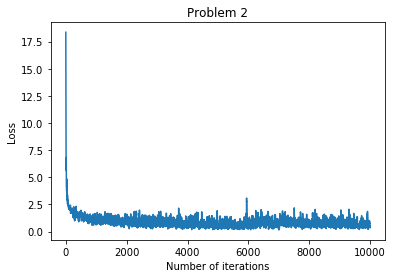

In [519]:
plt.plot(np.arange(10000),nnet.losspt[:10000])
plt.title('Problem 2')
plt.ylabel("Loss")
plt.xlabel("Number of iterations")
plt.show()

In [516]:
p = nnet.predict(plet_v,sigmoid=True)
truec = let_v_label[(p-let_v_label ==0).T[0]]
predicted = nnet.predict(plet_v[(p-let_v_label !=0).T[0]],sigmoid=True)
true = let_v_label[(p-let_v_label !=0).T[0]]

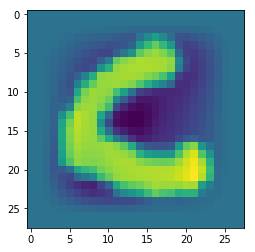

True Label: [3]


In [520]:
plt.imshow(plet_v[(p-let_v_label ==0).T[0]][0].reshape(28,28))
plt.show()
print("True Label:",truec[0])

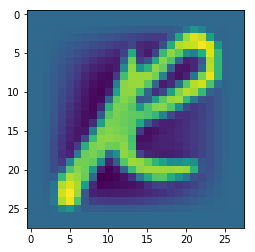

True Label: [18]


In [521]:
plt.imshow(plet_v[(p-let_v_label ==0).T[0]][1].reshape(28,28))
plt.show()
print("True Label:",truec[1])

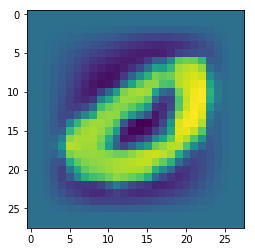

True Label: [15]


In [522]:
plt.imshow(plet_v[(p-let_v_label ==0).T[0]][2].reshape(28,28))
plt.show()
print("True Label:",truec[2])

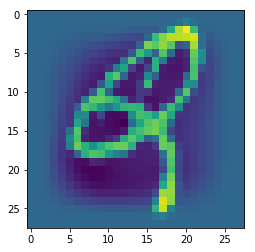

True Label: [17]


In [523]:
plt.imshow(plet_v[(p-let_v_label ==0).T[0]][3].reshape(28,28))
plt.show()
print("True Label:",truec[3])

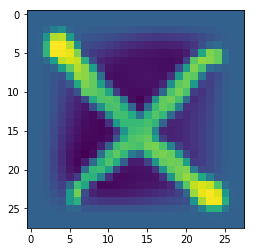

True Label: [24]


In [524]:
plt.imshow(plet_v[(p-let_v_label ==0).T[0]][4].reshape(28,28))
plt.show()
print("True Label:",truec[4])

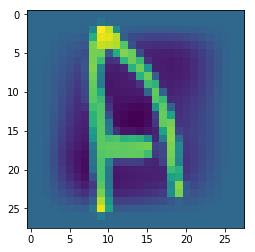

Predicted Label: [8]
True Label: [1]


In [525]:
plt.imshow(plet_v[(p-let_v_label !=0).T[0]][0].reshape(28,28))
plt.show()
print("Predicted Label:",predicted[0])
print("True Label:",true[0])

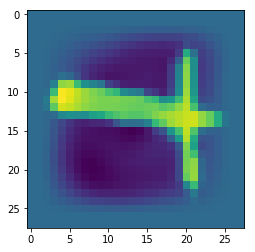

Predicted Label: [25]
True Label: [20]


In [526]:
plt.imshow(plet_v[(p-let_v_label !=0).T[0]][1].reshape(28,28))
plt.show()
print("Predicted Label:",predicted[1])
print("True Label:",true[1])

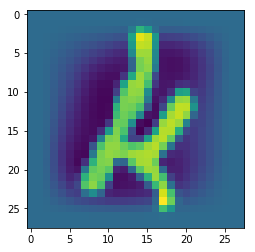

Predicted Label: [8]
True Label: [11]


In [527]:
plt.imshow(plet_v[(p-let_v_label !=0).T[0]][2].reshape(28,28))
plt.show()
print("Predicted Label:",predicted[2])
print("True Label:",true[2])

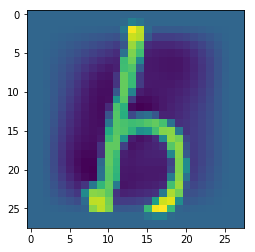

Predicted Label: [8]
True Label: [2]


In [528]:
plt.imshow(plet_v[(p-let_v_label !=0).T[0]][3].reshape(28,28))
plt.show()
print("Predicted Label:",predicted[3])
print("True Label:",true[3])

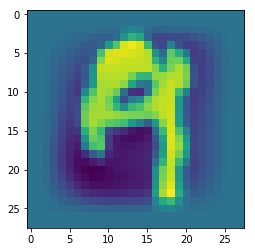

Predicted Label: [6]
True Label: [7]


In [529]:
plt.imshow(plet_v[(p-let_v_label !=0).T[0]][4].reshape(28,28))
plt.show()
print("Predicted Label:",predicted[4])
print("True Label:",true[4])

In [499]:
nnetf = NNet(h_units=200,gaus=True) 

In [500]:
t0 = time.time()
nnetf.train(plet,letters['train_y'],20,0.05,0.05,batch_size = 16,
            tanh=True,sigmoid=True,dropout=False,cool=True,plot=True)
t1 = time.time()
print(t1-t0)

1310.8310251235962


In [501]:
def output(self,path,data,zindex=0):
        np.savetxt(
        path, np.column_stack(
        (np.array(
            list(zindex+np.arange(data.shape[0]))),self.predict(
            data))).astype(int), 
        fmt ="%i",delimiter = ",", 
        header = "Id,Category",comments = "")

In [502]:
output(nnetf,"letkaggle.csv",plet_f,1)

![letter](letterkaggle.PNG)

In [7]:
let_t

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [8]:
let_t_label

array([[26],
       [19],
       [17],
       ..., 
       [22],
       [ 1],
       [ 3]], dtype=uint8)

In [472]:
nnet1 = NNet(h_units=200,gaus=True) 

In [473]:
t0 = time.time()
nnet1.train(plet_t,let_t_label,20,0.05,0.05,batch_size = 16,
            tanh=True,sigmoid=True,cool=True)
t1 = time.time()
print(t1-t0)

631.203414440155


In [474]:
nnet1.score(plet_v,let_v_label,tanh=True,sigmoid=True)

0.8642227564102565

In [475]:
nnet1.score(plet_t,let_t_label,tanh=True,sigmoid=True)

0.8845252403846153

In [2172]:
nnet2 = NNet(h_units=200)

In [2173]:
t0 = time.time()
nnet2.train(plet_t,let_t_label,5,0.0075,0.0075,batch_size = 5,
            tanh=True,sigmoid=True,dropout=True)
t1 = time.time()
print(t1-t0)

1497.3162744045258


In [2174]:
nnet2.score(plet_v,let_v_label,tanh=True,sigmoid=True,dropout=True)

0.7785657051282051

In [347]:
nnet3 = NNet(h_units=200)

In [348]:
t0 = time.time()
nnet3.train(plet_t,let_t_label,15,0.045,0.045,batch_size = 16,
            tanh=True,sigmoid=False,dropout=False)
t1 = time.time()
print(t1-t0)

402.39103627204895


In [349]:
nnet3.score(plet_v,let_v_label,tanh=True,sigmoid=False,dropout=False)

0.8280448717948719

In [114]:
nnet4 = NNet(h_units=200)

In [115]:
t0 = time.time()
nnet4.train(plet_t,let_t_label,15,0.02,0.02,batch_size = 4,
            tanh=True,sigmoid=False,dropout=True)
t1 = time.time()
print(t1-t0)

479.98267221450806


In [116]:
nnet4.score(plet_v,let_v_label,tanh=True,sigmoid=False,dropout=True)

0.8516826923076923

In [482]:
nnet5 = NNet(h_units=200,gaus=True)

In [483]:
t0 = time.time()
nnet5.train(plet_t,let_t_label,15,0.05,0.05,batch_size = 20,
            tanh=False,sigmoid=False,dropout=False,cool=True,plot=True)
t1 = time.time()
print(t1-t0)

744.196450471878


In [484]:
nnet5.score(plet_v,let_v_label,tanh=False,sigmoid=False,dropout=False)

0.7582932692307692

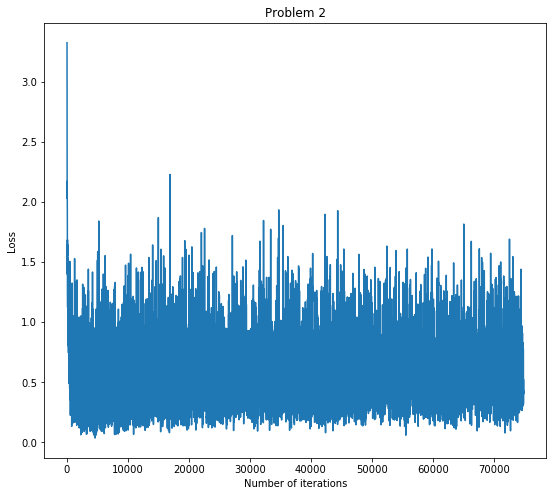

In [485]:
plt.plot(np.arange(len(nnet5.losspt)),nnet5.losspt)
plt.title('Problem 2')
plt.ylabel("Loss")
plt.xlabel("Number of iterations")
plt.show()